In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
from glob import glob
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import math
import cv2
%matplotlib inline

cwd = os.getcwd()
input_dir = os.path.join(os.path.dirname(cwd), 'data', 'crops_for_rot', 'wrap')
output_dir  = os.path.join(os.path.dirname(cwd), 'data', 'crops_for_rot', 'wrap')
TARGET_WIDTH = 550
TARGET_HEIGHT = 550

img_shape=(3, TARGET_HEIGHT, TARGET_WIDTH)

target_size = (TARGET_HEIGHT, TARGET_WIDTH)

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
input_dir

'/home/ubuntu/courses/deeplearning1/nbs/data/crops_for_rot/wrap'

In [19]:
test_ann = pd.read_csv('test_pts_550.csv')
tr_ann = pd.read_csv('pts_ann_550.csv')

In [20]:
len(tr_ann)

4544

In [21]:
len(test_ann)

6925

In [22]:
tr_ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,...,x_2,y_2,bboxx_new,bboxy_new,width_new,height_new,x1_550,x2_550,y1_550,y2_550
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591,w_7812.jpg,1668.211366,...,1647.792622,1108.737787,275.653042,192.437029,98.819015,98.819015,279.603345,257.407012,418.623052,134.509993
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137,w_4598.jpg,1639.625125,...,1353.762712,1265.962114,232.835803,198.918777,122.834636,93.500992,391.459051,141.465423,223.887078,284.879921
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429,w_3828.jpg,1118.947159,...,1345.595214,963.764706,207.168864,161.335045,117.334578,89.834286,53.967163,261.467454,98.812047,164.736023
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,1690.671984,...,1682.504487,1069.942173,292.325754,192.271040,65.934673,69.623326,317.162860,303.856236,368.880932,132.600235
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,1655.960120,...,1662.085743,878.005982,274.804652,125.875285,85.761183,105.126612,313.092517,320.765288,437.328361,239.115110


In [23]:
test_ann.head()

,Unnamed: 0,Image,x1_550,y1_550,x2_550,y2_550
0,0,w_8037.jpg,254.515167,339.450134,270.144104,80.565598
1,1,w_4494.jpg,312.916016,192.751953,247.354248,256.949921
2,2,w_4673.jpg,75.265251,206.645233,382.411560,162.701584
3,3,w_8273.jpg,152.168198,326.845825,284.177643,174.622955
4,4,w_7611.jpg,357.060730,137.456940,145.906723,328.053009


# Rotate

In [26]:
def checkPts(r, target_width, target_height, input_dir):
    r = r[1]
    path = os.path.join(input_dir, r.Image)
    print(path)
    im = cv2.imread(path)
    sm = cv2.resize(im, (TARGET_WIDTH, TARGET_HEIGHT))
    fig, ax = plt.subplots()
    ax.imshow(sm)
    ax.scatter(r.x1_550, r.y1_550, s=20, c='red', marker='o')
    ax.scatter(r.x2_550, r.y2_550, s=20, c='yellow', marker='o')

    #cv2.imwrite(os.path.join(save_dir, r.Image), rot_n)
    
    plt.show()

/home/ubuntu/courses/deeplearning1/nbs/data/crops_for_rot/wrap/w_7916.jpg


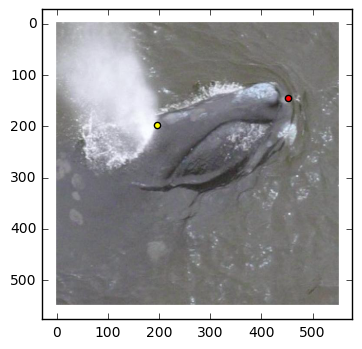

In [49]:
for row in test_ann.iloc[6091:, :].iterrows():
    #print(row[1].Image)
        #if row[1].Image not in g: continue
    #print('through')
    checkPts(row, target_width, target_height, input_dir)
    break
    #print(row[1].height)

In [56]:
def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height, pt1, pt2):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """
    image_size = (image.shape[1], image.shape[0])
    
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))
    image_center_2 = (int((pt1[0] + pt2[0]) * 0.5), int((pt1[1] + pt2[1]) * 0.5))
    
    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]
    
    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

In [79]:
def crop_and_align(r, target_width, target_height, input_dir, save_dir):
    path = os.path.join(input_dir, r.Image)
    im = cv2.imread(path)
    sm = cv2.resize(im, (TARGET_WIDTH, TARGET_HEIGHT))
    ang = bearing(r.x1_550, r.y1_550, r.x2_550, r.y2_550)
    rot = rotate_image(sm, ang)
    w, h = largest_rotated_rect(TARGET_WIDTH, TARGET_HEIGHT, math.radians(ang))
    rot = crop_around_center(rot,w,h,  (r.y1_550, r.x1_550 ), (r.y2_550, r.x2_550))
    cv2.imwrite(os.path.join(save_dir, r.Image), rot)

In [80]:
i = 0
for row in tr_ann.iterrows():
    i+=1
    if i % 100 == 0: print(i)
    data = row[1]
    crop_and_align(data, TARGET_WIDTH, TARGET_HEIGHT, input_dir, output_dir)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500


In [81]:
i = 0
for row in test_ann.iterrows():
    i+=1
    if i % 100 == 0: print(i)
    data = row[1]
    crop_and_align(data, TARGET_WIDTH, TARGET_HEIGHT, input_dir, output_dir)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900


# Check

In [82]:
% cd $output_dir

/home/ubuntu/courses/deeplearning1/nbs/data/crops_for_rot/wrap


In [83]:
g = glob('*.jpg')

In [84]:
len(g)

11469

In [101]:
def checkImgs(g):
    p = np.random.permutation(g)
    for f in p[:5]:
        im = cv2.imread(f)
        print(im.shape)
        ax = plt.gca()
        ax.imshow(im)
        plt.show()

(545, 545, 3)


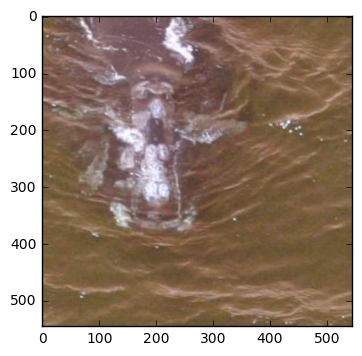

(539, 539, 3)


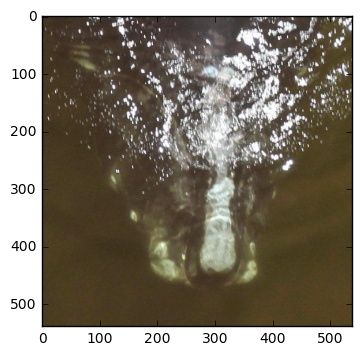

(473, 473, 3)


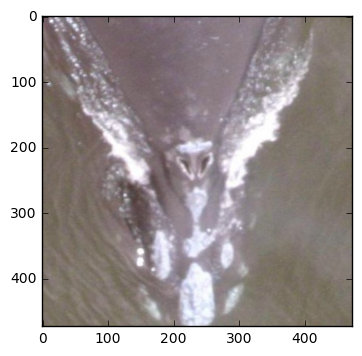

(445, 445, 3)


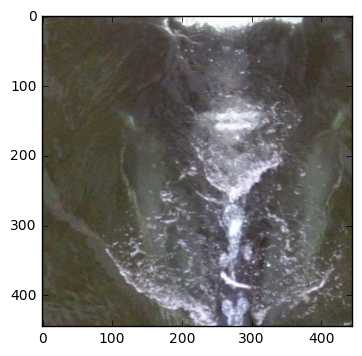

(389, 389, 3)


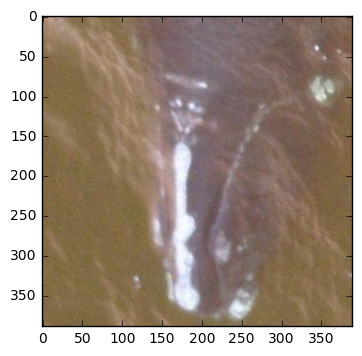

In [102]:
checkImgs(g)